# Summary

- Fine-tune a pretrained LLM for POS

In [ ]:
%pip install -qU transformers datasets evaluate seqeval click

In [ ]:
%pip install accelerate -qU

In [ ]:
import os
from pprint import pprint
from pathlib import Path

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from datasets import load_dataset

In [ ]:
root_dir = Path.cwd()
root_dir

PosixPath('/content')

In [ ]:
dataset_checkpoint = "ndamulelonemakh/za_pos"
model_checkpoint = "dsfsi/zabantu-ven-120m"
push_to_hub = True
local_checkpoint_dir = root_dir / "data/checkpoints/zabantu-ven-120m-pos-tshivenda"

epochs = 1   # for testing purposes
batch_size = 4
max_length = 512

In [ ]:
from huggingface_hub import notebook_login, whoami

try:
    whoami()
except:
    notebook_login()

# Get Data

In [ ]:
raw_datasets = load_dataset(dataset_checkpoint, name="ven")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags', 'lang'],
        num_rows: 665
    })
    validation: Dataset({
        features: ['tokens', 'tags', 'lang'],
        num_rows: 83
    })
    test: Dataset({
        features: ['tokens', 'tags', 'lang'],
        num_rows: 84
    })
})

In [ ]:
raw_datasets['train'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'tags': Sequence(feature=ClassLabel(names=['B-ADJ', 'B-ADV', 'B-NOUN', 'B-PREP', 'B-VERB', 'I-ADJ', 'I-NOUN', 'I-VERB', 'OUT'], id=None), length=-1, id=None),
 'lang': Value(dtype='string', id=None)}

In [ ]:
text_column = "tokens"
label_column = "tags"

In [ ]:
class_names = raw_datasets['train'].features['tags'].feature.names
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}
pprint(class_names)

['B-ADJ',
 'B-ADV',
 'B-NOUN',
 'B-PREP',
 'B-VERB',
 'I-ADJ',
 'I-NOUN',
 'I-VERB',
 'OUT']


# Get Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, \
    DataCollatorForTokenClassification

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint,
                                                        num_labels=len(class_names),
                                                        id2label=id2label,
                                                        label2id=label2id)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True, model_max_length=512)
label_all_tokens = True

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at dsfsi/zabantu-ven-120m and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Preprocess

- Model expects input in the form of a list of integers, where each integer corresponds to a token in the vocabulary. The model also expects a list of integers, where each integer corresponds to a label in the label set.
- In huggingface, the model expects the input in the form of a dictionary with keys `input_ids` and `labels`.

In [ ]:
def preprocess_function(examples: dict) -> dict:
    tokenized_inputs = tokenizer(examples[text_column],
                                    truncation=True,
                                    is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples[label_column]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


columns_to_drop = [col for col in raw_datasets['train'].column_names]
                    # if col not in [text_column, label_column]]
encoded_datasets = raw_datasets.map(preprocess_function,
                                    batched=True,
                                    num_proc=os.cpu_count() * 2,
                                    remove_columns=columns_to_drop)
encoded_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 665
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 83
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 84
    })
})

In [ ]:
# Data collator is called to get next batch of data,
# it will pad the data to the maximum length of the batch
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Train

In [ ]:
import evaluate

In [ ]:
metric = evaluate.load("seqeval")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, tl) in zip(prediction, label) if tl != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[tl] for (p, tl) in zip(prediction, label) if tl != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
args = TrainingArguments(
    local_checkpoint_dir.as_posix(),
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    push_to_hub=push_to_hub,
    save_total_limit=1
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_datasets["train"],
    eval_dataset=encoded_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.468125,0.823038,0.859634,0.840938,0.855131


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: OUT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


TrainOutput(global_step=167, training_loss=0.7350105696809506, metrics={'train_runtime': 35.8283, 'train_samples_per_second': 18.561, 'train_steps_per_second': 4.661, 'total_flos': 11451059128494.0, 'train_loss': 0.7350105696809506, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: OUT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.4681253433227539,
 'eval_precision': 0.8230383973288815,
 'eval_recall': 0.8596338273757629,
 'eval_f1': 0.8409381663113007,
 'eval_accuracy': 0.8551307847082495,
 'eval_runtime': 0.3879,
 'eval_samples_per_second': 213.988,
 'eval_steps_per_second': 54.141,
 'epoch': 1.0}

In [ ]:
sample_text = raw_datasets['test'].shuffle()[-1]['tokens']
sample_text

['Kha',
 'vha',
 'vhale',
 'fomo',
 'ya',
 'khumbelo',
 'nga',
 'vhuronwane',
 'nahone',
 'vha',
 'vhone',
 'uri',
 'vha',
 'fusha',
 'ṱhoḓea',
 'dzoṱhe',
 'dza',
 'khumbelo',
 '.']

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("token-classification", model=trainer.model, tokenizer=tokenizer, device=0)

In [ ]:
from pprint import pprint

sample_prediction = pipe(sample_text)
pprint(sample_prediction)

[[{'end': 1,
   'entity': 'B-NOUN',
   'index': 1,
   'score': 0.65769863,
   'start': 0,
   'word': '▁'},
  {'end': 1,
   'entity': 'B-NOUN',
   'index': 2,
   'score': 0.43019685,
   'start': 0,
   'word': 'K'},
  {'end': 3,
   'entity': 'B-NOUN',
   'index': 3,
   'score': 0.603958,
   'start': 1,
   'word': 'ha'}],
 [{'end': 3,
   'entity': 'B-NOUN',
   'index': 1,
   'score': 0.4864361,
   'start': 0,
   'word': '▁vha'}],
 [{'end': 5,
   'entity': 'B-VERB',
   'index': 1,
   'score': 0.5865077,
   'start': 0,
   'word': '▁vhale'}],
 [{'end': 4,
   'entity': 'B-NOUN',
   'index': 1,
   'score': 0.86941147,
   'start': 0,
   'word': '▁fomo'}],
 [{'end': 2,
   'entity': 'OUT',
   'index': 1,
   'score': 0.48558617,
   'start': 0,
   'word': '▁ya'}],
 [{'end': 8,
   'entity': 'B-NOUN',
   'index': 1,
   'score': 0.9637129,
   'start': 0,
   'word': '▁khumbelo'}],
 [{'end': 3,
   'entity': 'B-NOUN',
   'index': 1,
   'score': 0.46816188,
   'start': 0,
   'word': '▁nga'}],
 [{'end': 10

# Full evaluation

In [ ]:
import json
import click

import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
encoded_datasets['test'][1]['input_ids']

[0,
 84950,
 3,
 8837,
 63,
 84950,
 3,
 1274,
 1203,
 21,
 44,
 3,
 7115,
 24,
 1738,
 24,
 685,
 21,
 995,
 2]

In [ ]:
raw_datasets['test'][1]

{'tokens': ['ṋomboro',
  'dza',
  'ID',
  ',',
  'madzina',
  'na',
  'maḓuvha',
  'a',
  'mabebo',
  'a',
  'munna',
  'na',
  'mufumakadzi'],
 'tags': [2, 8, 2, 8, 2, 8, 2, 8, 2, 8, 2, 8, 2],
 'lang': 'ven'}

In [ ]:
tokenizer.decode(encoded_datasets['test'][1]['input_ids'], is_split_into_words=True).split()

['<s>',
 '<unk>omboro',
 'dza',
 '<unk>,',
 'madzina',
 'na',
 'ma<unk>uvha',
 'a',
 'mabebo',
 'a',
 'munna',
 'na',
 'mufumakadzi</s>']

Running full eval. ArtifactsDir=/content/data/checkpoints/zabantu-ven-120m-pos-tshivenda/eval


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: OUT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<class 'dict'>
Final test scores:  {'ADJ': {'precision': 0.9375, 'recall': 0.5769230769230769, 'f1': 0.7142857142857143, 'number': 78}, 'ADV': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 23}, 'NOUN': {'precision': 0.7960954446854663, 'recall': 0.935031847133758, 'f1': 0.8599882835383715, 'number': 785}, 'PREP': {'precision': 0.9156626506024096, 'recall': 0.7037037037037037, 'f1': 0.7958115183246074, 'number': 108}, 'VERB': {'precision': 0.8641025641025641, 'recall': 0.8663239074550129, 'f1': 0.865211810012837, 'number': 389}, 'overall_precision': 0.8260568260568261, 'overall_recall': 0.8618944323933478, 'overall_f1': 0.8435951875442322, 'overall_accuracy': 0.8547486033519553}
--------------------------------------------------
              precision    recall  f1-score   support

       B-ADJ       0.94      0.58      0.71        78
       B-ADV       0.00      0.00      0.00        23
      B-NOUN       0.80      0.94      0.86       785
      B-PREP       0.92      0.70   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

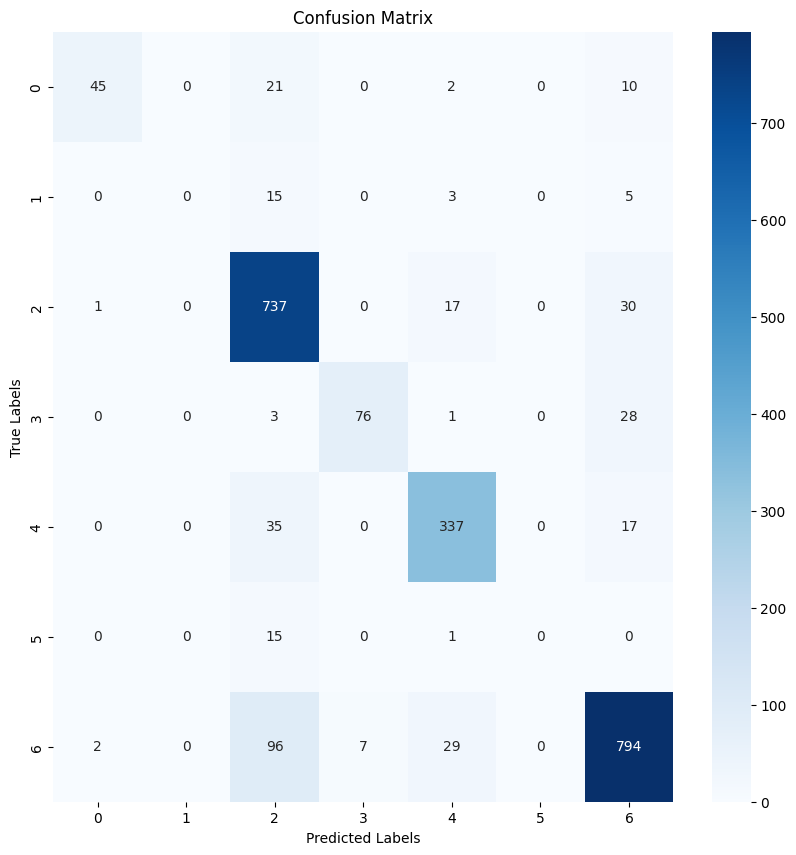

In [ ]:
def full_evaluation(test_dataset: Dataset,
                    trainer: Trainer,
                    output_dir: Path,
                    id2label: dict[int, str],
                    class_names: list[str]) -> Path:
    print(f"Running full eval. ArtifactsDir={output_dir}")
    predictions, labels, _ = trainer.predict(test_dataset)
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    predicted_labels = [
        [id2label[p] for (p, tl) in zip(prediction, label) if tl != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [id2label[tl] for (p, tl) in zip(prediction, label) if tl != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # save final scores
    scores = metric.compute(predictions=predicted_labels, references=true_labels)
    print(type(scores))
    print("Final test scores: ", scores)
    output_dir.joinpath("scores.json").write_text(str(scores))

    # flatten predictions
    predicted_labels = [item for sublist in predicted_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Make sure the output directory exists
    output_dir.mkdir(parents=True, exist_ok=True)

    print('-' * 50)
    report = classification_report(true_labels, predicted_labels)
    print(report)
    with open(output_dir / "classification_report.json", "w") as f:
        json.dump(classification_report(true_labels,
                                        predicted_labels,
                                        target_names=class_names,
                                        labels=np.arange(len(class_names)),
                                        output_dict=True), f, indent=4)

    # confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    unique_class_names = np.unique(true_labels).tolist()
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True,
                fmt='d',
                xticklabels=unique_class_names,
                yticklabels=unique_class_names,
                cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    fig.savefig(output_dir / "confusion_matrix.png", dpi=300, format='png')

    # save the predictions
    with open(output_dir / "predictions.csv", "w") as f:
      pd.DataFrame({
              # "tokens": [t for tl in tokens for t in tl],
              "tags": true_labels,
              "predicted_labels": predicted_labels
      }).to_csv(f, index=False)

    return output_dir


artifacts_dir = full_evaluation(encoded_datasets["test"],
                                trainer,
                                local_checkpoint_dir.joinpath('eval'),
                                id2label,
                                class_names)